<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#General" data-toc-modified-id="General-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>General</a></span></li><li><span><a href="#Export-for-plots" data-toc-modified-id="Export-for-plots-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Export for plots</a></span></li></ul></div>

Calculation for a CPW where the center conductor is made up of unit cells of series L+Lj and a capacitance to ground, using the **fully analytical** model.

We downscale the CPW because we want the unit cells to be as small as possible. We choose a unit cell length of 1um and for this we shrink the CPW by a factor of 10. CPW parameters are calculated with the following code:

```python
from tlineformulas import getlinepars
geo = {'s': 1e-6, 'w': .6e-6, 't': 80e-9, 'london': 158e-9, 'epsr': 11.9}
tlpars = getlinepars(geo)
[print(str(key)+':', val) for key, val in tlpars.items()]
print()
```

# General

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import pickle
c = const.c
pi = np.pi
e = const.e
hbar = const.hbar
h = const.Planck
Phi0 = h/(2*e)

In [2]:
# Cavity parameters (per length)

Cg = 1.6940741661078421e-10 # geometric capacitance, in F/m
Lg = 4.23629201431845e-07 # geometric inductance, in H/m
Lk = 4.188210237203963e-07 # kinetic inductance, in H/m
Lprime = Lg+Lk # linear inductance, in H/m
Cprime = Cg # capacitance, in F/m

# Additional parameters
Cs = 24e-12 # shunt capacitor, in F
Ic = 9.176e-6 # critical current, in A

In [3]:
# variables:
# I - bias current, in A
# Ic - critical current, in A
# l - unit cell length, in m
# f0fix - intended zero-bias resonance frequency, in Hz
# N - total number of unit cells, dimensionless

def Lj(I=0,Ic=9.176e-6):
    # Josephson inductance of a single junction, also per unit cell, in H
    return Phi0/(2*pi*np.sqrt(Ic**2-I**2))

def Ln(I=0,Ic=9.176e-6,l=1e-6):
    # inductance per unit cell, in H
    return Lprime*l + Lj(I,Ic)

def Lambda(Ic=9.176e-6,l=1e-6):
    # linear inductance per unit cell inductance, dimensionless
    return Lprime*l/Ln(I=0,Ic=Ic,l=l)

def ln(Ic=9.176e-6,N=1,f0fix=7.5e9):
    # unit cell length, as a function of number of unit cells, in m
    # this at zero bias current
    w0fix = 2*pi*f0fix
    aux1 = 1/(2*Lprime)
    aux2 = -Lj(I=0,Ic=Ic)
    aux3 = 1/(w0fix*np.sqrt(Cprime))
    aux4 = np.sqrt(8*Lprime+Cprime*Lj(I=0,Ic=Ic)**2 *w0fix**2 - 8*Lprime*np.cos(pi/N))
    return aux1*(aux2+aux3*aux4)

def Nl(Ic=9.176e-6,l=1e-6,f0fix=7.5e9):
    # unit cell number, as a function of number of unit cell length, dimensionless
    # this at zero bias current
    w0fix = 2*pi*f0fix
    return (pi / np.arccos( 1-w0fix**2 *(Lprime*l+Lj(I=0,Ic=Ic))*Cprime*l/2)).astype(int)

In [4]:
# Anharmonicity
# Analytical formulas

def wm(m,N,Lj,L0,Cj,C0):
    c = np.cos(np.pi*m/N)
    return 1/np.sqrt((Lj+L0)*(Cj+C0/(2-2*c)))
def zpf_1(m,N,Lj,L0,Cj,C0):
    c = np.cos(np.pi*m/N)
    imY = N*(C0-2*Cj*(c-1))/(1-c**2)
    return np.sqrt(hbar/wm(m,N,Lj,L0,Cj,C0)/imY)
def ev(m,n,N,Lj,L0,Cj,C0):
    return np.sqrt(2/N)*np.sin(np.pi*m*n/N)
def zpf_n(m,n,N,Lj,L0,Cj,C0):
    return zpf_1(m,N,Lj,L0,Cj,C0)*(ev(m,n,N,Lj,L0,Cj,C0)-ev(m,n-1,N,Lj,L0,Cj,C0))/ev(m,1,N,Lj,L0,Cj,C0)
def anh(m,N,Lj,L0,Cj,C0):
    phi0 = hbar/2/e
    return (Lj/(Lj+L0))**4/2/phi0**2/Lj*sum([np.absolute(zpf_n(m,n,N,Lj,L0,Cj,C0))**4 for n in range(1,N+1)])/h

In [5]:
ii = np.linspace(0,9e-6,201) # all bias currents, in A
nn = np.unique(np.around(np.logspace(1,3.5,201)).astype(int)) # total number of unit cells, dimensionless
ll = ln(N=nn) # all unit cell lengths, in m
print("Number of unit cells")
f_of_n = wm(m=1,N=nn,Lj=Lj(I=0,Ic=Ic),L0=Lprime*ll,Cj=0,C0=Cprime*ll)/2/pi

Number of unit cells


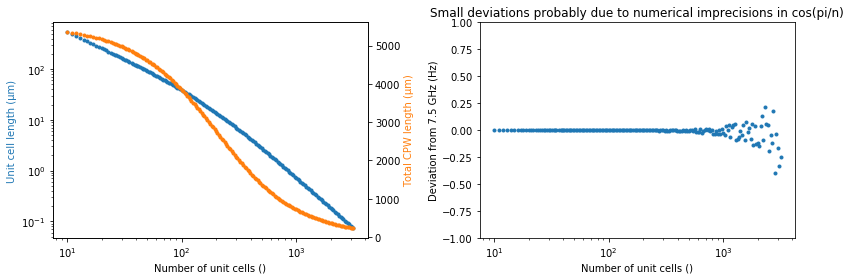

In [6]:
fig,(axa,axb)=plt.subplots(1,2,figsize=(12,4))

plt.sca(axa)
plt.plot(nn,ll/1e-6,'C0.')
plt.yscale('log')
plt.xlabel('Number of unit cells ()')
plt.ylabel('Unit cell length (µm)',c='C0')
ax2 = plt.gca().twinx()
plt.plot(nn,ll*nn/1e-6,'C1.')
plt.ylabel('Total CPW length (µm)',c='C1')
# plt.yscale('log')
plt.xscale('log')
# plt.grid(which='both')

plt.sca(axb)
plt.plot(nn,(f_of_n-7.5e9),'.')
plt.xlabel('Number of unit cells ()')
plt.ylabel('Deviation from 7.5 GHz (Hz)')
plt.ylim(-1,1)
plt.xscale('log')

plt.title('Small deviations probably due to numerical imprecisions in cos(pi/n)')

plt.tight_layout()


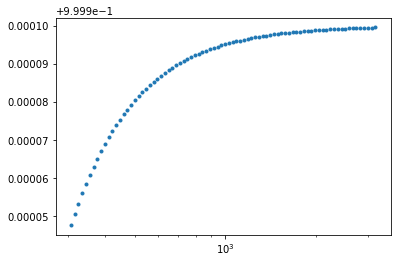

In [7]:
plt.plot(nn[100:],np.cos(pi/nn[100:]),'.')
# plt.yscale('log')
plt.xscale('log')

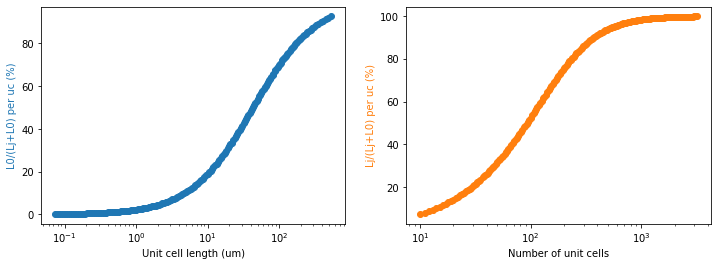

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
plt.sca(ax1)
plt.plot(ll/1e-6,Lambda(l=ll)*100,'C0o')
plt.xscale('log')
plt.xlabel('Unit cell length (um)')
plt.ylabel('L0/(Lj+L0) per uc (%)',c='C0')
plt.sca(ax2)
plt.plot(nn,(1-Lambda(l=ll))*100,'C1o')
plt.xscale('log')
plt.xlabel('Number of unit cells')
plt.ylabel('Lj/(Lj+L0) per uc (%)',c='C1')
plt.show()
plt.close()

In [9]:
X,Yn = np.meshgrid(ii,nn)
X,Yl = np.meshgrid(ii,ll)

In [10]:
Anh = np.array([anh(m=1,N=N,Lj=Lj(I=ii,Ic=Ic),L0=Lprime*l,Cj=0,C0=Cprime*l) for l,N in zip(ll,nn)])
Anh_linecut = Anh[:,0]

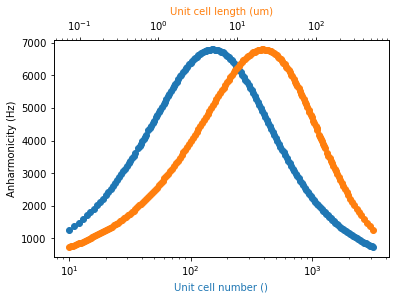

In [11]:
fig,ax1 = plt.subplots(1,1)
plt.ylabel('Anharmonicity (Hz)')
# plt.yscale('log')
# plt.grid(which='both',c='C0')
ax2 = ax1.twiny()
line1, = ax1.plot(nn,Anh_linecut,'C0o',label='N')
line2, = ax2.plot(ll/1e-6,Anh_linecut,'C1o',label='l')
ax1.set_xscale('log')
ax1.set_xlabel('Unit cell number ()',color='C0')
ax2.set_xscale('log')
ax2.set_xlabel('Unit cell length (um)',color='C1')
# plt.grid(which='both',c='C1')
# plt.ylim(0,7e3)
plt.show()
plt.close()

In [12]:
nmax = np.argmax(Anh_linecut)
nn[nmax],Anh_linecut[nmax]

(150, 6795.184703910467)

In [13]:
fmcurrs = wm(m=1,N=Yn,Lj=Lj(I=ii,Ic=Ic),L0=Lprime*Yl,Cj=0,C0=Cprime*Yl)/2/pi

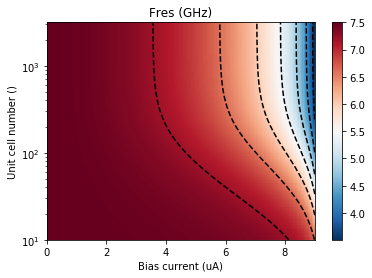

In [14]:
plt.contour(X/1e-6,Yn,fmcurrs/1e9,colors='k',linestyles='dashed')
plt.pcolormesh(X/1e-6,Yn,fmcurrs/1e9,cmap='RdBu_r')
plt.colorbar()
plt.yscale('log')
plt.xlabel('Bias current (uA)')
plt.ylabel('Unit cell number ()')
plt.title('Fres (GHz)')
plt.show()
plt.close()

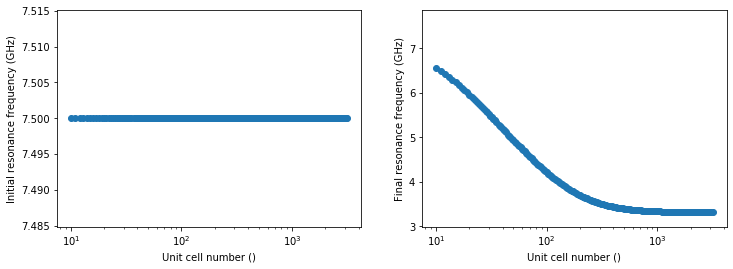

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
plt.sca(ax1)
# plt.axhline(7.5,c='C1')
plt.scatter(nn,fmcurrs[:,0]/1e9)
plt.xscale('log')
plt.xlabel('Unit cell number ()')
plt.ylabel('Initial resonance frequency (GHz)')
plt.sca(ax2)
plt.scatter(nn,fmcurrs[:,-1]/1e9)
plt.xscale('log')
plt.xlabel('Unit cell number ()')
plt.ylabel('Final resonance frequency (GHz)')
plt.ylim(np.min(fmcurrs)/1e9*0.9,np.max(fmcurrs)/1e9*1.05)
# plt.ylim(5.2,7.5)
plt.show()
plt.close()

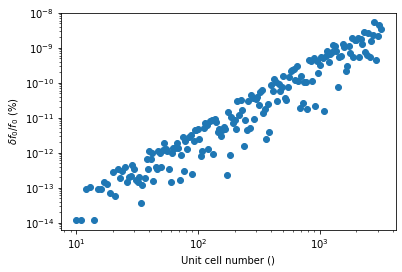

In [16]:
plt.plot(nn,abs(fmcurrs[:,0]/1e9-7.5)/7.5*100,'o')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Unit cell number ()')
plt.ylabel('$\delta f_0/f_0$ (%)')
plt.show()
plt.close()

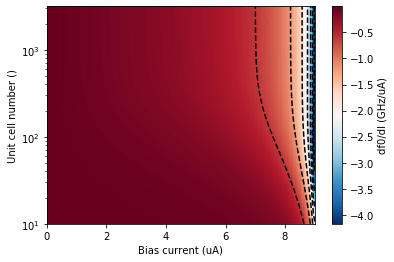

In [17]:
G1 = np.gradient(fmcurrs,axis=1)/np.gradient(X)[1]
plt.contour(X/1e-6,Yn,G1/(1e9/1e-6),colors='k',linestyles='dashed')
plt.pcolormesh(X/1e-6,Yn,G1/(1e9/1e-6),cmap='RdBu_r')
plt.colorbar(label='df0/dI (GHz/uA)')
plt.yscale('log')
plt.xlabel('Bias current (uA)')
plt.ylabel('Unit cell number ()')
#plt.grid()#which='both')
plt.show()
plt.close()

In [18]:
# for l=1um
myl = 1e-6
myn = Nl(l=myl)
print(myl, myn)
myanh = anh(m=1,N=myn,Lj=Lj(I=ii,Ic=Ic),L0=Lprime*myl,Cj=0,C0=Cprime*myl)

1e-06 845


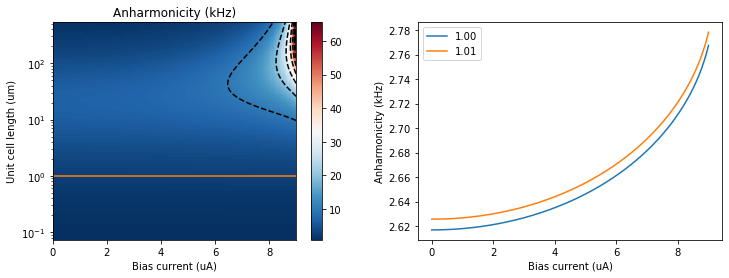

In [19]:
idx = 135

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
plt.sca(ax1)
plt.contour(X/1e-6,Yl/1e-6,Anh/1e3,colors='k',linestyles='dashed')
plt.pcolormesh(X/1e-6,Yl/1e-6,Anh/1e3,cmap='RdBu_r')
plt.axhline(Yl[idx,0]/1e-6,c='tab:orange')
plt.colorbar()
plt.yscale('log')
plt.xlabel('Bias current (uA)')
plt.ylabel('Unit cell length (um)')
plt.title('Anharmonicity (kHz)')
plt.sca(ax2)
plt.plot(ii/1e-6,myanh/1e3,label='%.2f' % (myl/1e-6))
plt.plot(X[idx,:]/1e-6,Anh[idx,:]/1e3,label='%.2f' % (Yl[idx,0]/1e-6))
plt.legend()
plt.xlabel('Bias current (uA)')
plt.ylabel('Anharmonicity (kHz)')
plt.show()
plt.close()

In [20]:
import pickle
# Export the 1um anharmonicity
myf0 = wm(m=1,N=myn,Lj=Lj(I=ii,Ic=Ic),L0=Lprime*myl,Cj=0,C0=Cprime*myl)/2/pi
mydict = {'l':myl,'N':myn,'I':ii,'Anh':myanh,'f0':myf0}
pickle.dump(mydict,open('data_processed/JJarrayCPW_analytical_1um_pars.pkl','wb'))

# Export for plots

In [21]:
1-Lambda(l=myl)

0.9770502072098798

In [22]:
(myf0[0]-myf0[-1])/myf0[0]

0.5543687031264746

In [23]:
finalpkl1 = {'N ()':nn,'l (m)':ll,'l0 (m)':nn*ll,'Lambda (%)':Lambda(l=ll)*100,'Anh (Hz)':Anh_linecut}
finalpkl2 = mydict
pickle.dump(finalpkl1,open('data_final/JJarrayCPW_pkl1.pkl','wb'))
pickle.dump(finalpkl2,open('data_final/JJarrayCPW_pkl2.pkl','wb'))

In [24]:
import stlabutils
import pandas as pd
import pickle

zvals = [Anh,fmcurrs]
ztitles = ['Anharmonicity (Hz)','Resonance frequency (Hz)']
shortkeys = ['Anh','f0']
for shortkey,zval,ztitle in zip(shortkeys,zvals,ztitles):
    mydf = pd.DataFrame(zval,columns=ii)
    mymtx = stlabutils.utils.stlabdict.stlabmtx(mydf,
                                                xtitle='Bias current (A)',
                                                ytitle='Index ()',
                                                ztitle=ztitle)

    mymtx.savemtx('data_processed/JJarrayCPW_analytical_1um'+shortkey)
    mypkl = [X,Yn,Yl,zval]
    pickle.dump(mypkl,open('data_processed/JJarrayCPW_analytical_1um'+shortkey+'.pkl','wb'))

(182, 201)
36582
(182, 201)
36582


In [25]:
pkl_main = pickle.load(open('data_final/fig2_panel_f0fit.pkl', 'rb'))
pkl_JJCPW = pickle.load(open('data_processed/JJarrayCPW_analytical_1um_pars.pkl', 'rb'))

In [26]:
pkl_JJCPW.keys(),pkl_main.keys()

(dict_keys(['l', 'N', 'I', 'Anh', 'f0']),
 dict_keys(['x1', 'y1', 'label', 'xtheo', 'ytheo', 'xlabel', 'ylabel', 'params']))

In [27]:
Ib = pkl_JJCPW['I']
f0_JJCPW = pkl_JJCPW['f0']

In [28]:
from src.model_currentbias import f0 as f0model
params_main = pkl_main['params']

In [29]:
params_main

name,value,standard error,relative error,initial value,min,max,vary
fr,7.5154e+09,281606.857,(0.00%),7560200000.0,-inf,inf,True
Lr,3.4011e-09,1.2858e-11,(0.38%),4e-09,-inf,inf,True
Ic,9.1567e-06,4.1831e-09,(0.05%),9e-06,-inf,inf,True
nJJ,1.00000000,0.00000000,(0.00%),1,-inf,inf,False


In [30]:
f0_main = f0model(Ib,fr = params_main['fr'],Lr=params_main['Lr'],Ic=params_main['Ic'])

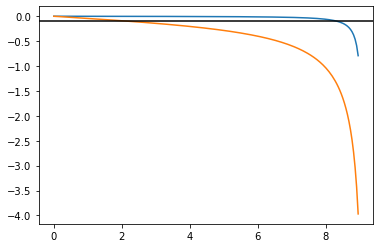

In [31]:
imax = 1
plt.plot(Ib[:-imax]/1e-6,np.gradient(f0_main/1e9,Ib/1e-6)[:-imax])
plt.plot(Ib[:-imax]/1e-6,np.gradient(f0_JJCPW/1e9,Ib/1e-6)[:-imax])
plt.axhline(-0.1,c='k')